<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/carry/Simple_Analysis_of_Carry_Effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Analysis of Carry Effects

* Does funding rate predict future funding returns?
* Does funding rate predict future price moves?


In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'roll'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpSWWzQN/remotes1382f41955e/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’



# What data do we want?

* Perp prices
* Perp funding rates

In [2]:
rwlab_data_auth()

Authorization successful!

In [3]:
# snippet: rw crypto load ftx futures v0.1
futures <- rwRtools::crypto_get_futures()

futures %>% 
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

# snippet: rw crypto load ftx perpetual funding rates v0.1
perp_rate <- rwRtools::crypto_get_perp_rates()

perp_rate %>%
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 232.4…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-07-20 12:00:00,2022-11-12


ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rates.…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-03-06 15:00:00,2022-11-12


# Let's look at our data

We'll only look at BTC-PERP today.

In [4]:
futures %>%  
  filter(ticker == 'BTC-PERP') %>%
  head()

ticker,date,open,high,low,close,volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTC-PERP,2019-07-20 12:00:00,10564.25,10630.00,10525.50,10539.50,10529974
BTC-PERP,2019-07-20 13:00:00,10539.50,10796.25,10477.00,10548.75,23616703
BTC-PERP,2019-07-20 14:00:00,10548.75,10628.25,10548.75,10621.25,16519347
BTC-PERP,2019-07-20 15:00:00,10621.25,10675.75,10579.75,10647.50,5936653
BTC-PERP,2019-07-20 16:00:00,10644.25,10881.75,10608.75,10821.00,20003625
BTC-PERP,2019-07-20 17:00:00,10826.75,11053.25,10816.25,10913.50,9159351


In [5]:
perp_rate %>%
  filter(ticker == 'BTC-PERP') %>%
  head()

ticker,date,rate
<chr>,<dttm>,<dbl>
BTC-PERP,2019-03-06 15:00:00,-0.00001
BTC-PERP,2019-03-06 16:00:00,-0.00002
BTC-PERP,2019-03-06 17:00:00,-0.00002
BTC-PERP,2019-03-06 18:00:00,-0.00002
BTC-PERP,2019-03-06 19:00:00,-0.00025
BTC-PERP,2019-03-06 20:00:00,-0.00025


Posstiive rate is longs pay shorts
Negative is shorts pay longs

In [6]:
BTC <- futures %>% 
   filter(ticker == 'BTC-PERP') %>%
   inner_join(perp_rate, by = c('ticker','date')) %>%
   na.omit()

Calculate returns

In [7]:
BTC <- BTC %>%
  arrange(date) %>%
  mutate(
    price_change = log(close / lag(close)),
    funding_accrual = -lead(rate),
    funding_rate = -roll_mean(rate, 24)
  ) %>% 
  na.omit()

Is funding rate predictive of future funding rate.

`geom_smooth()` using formula = 'y ~ x'


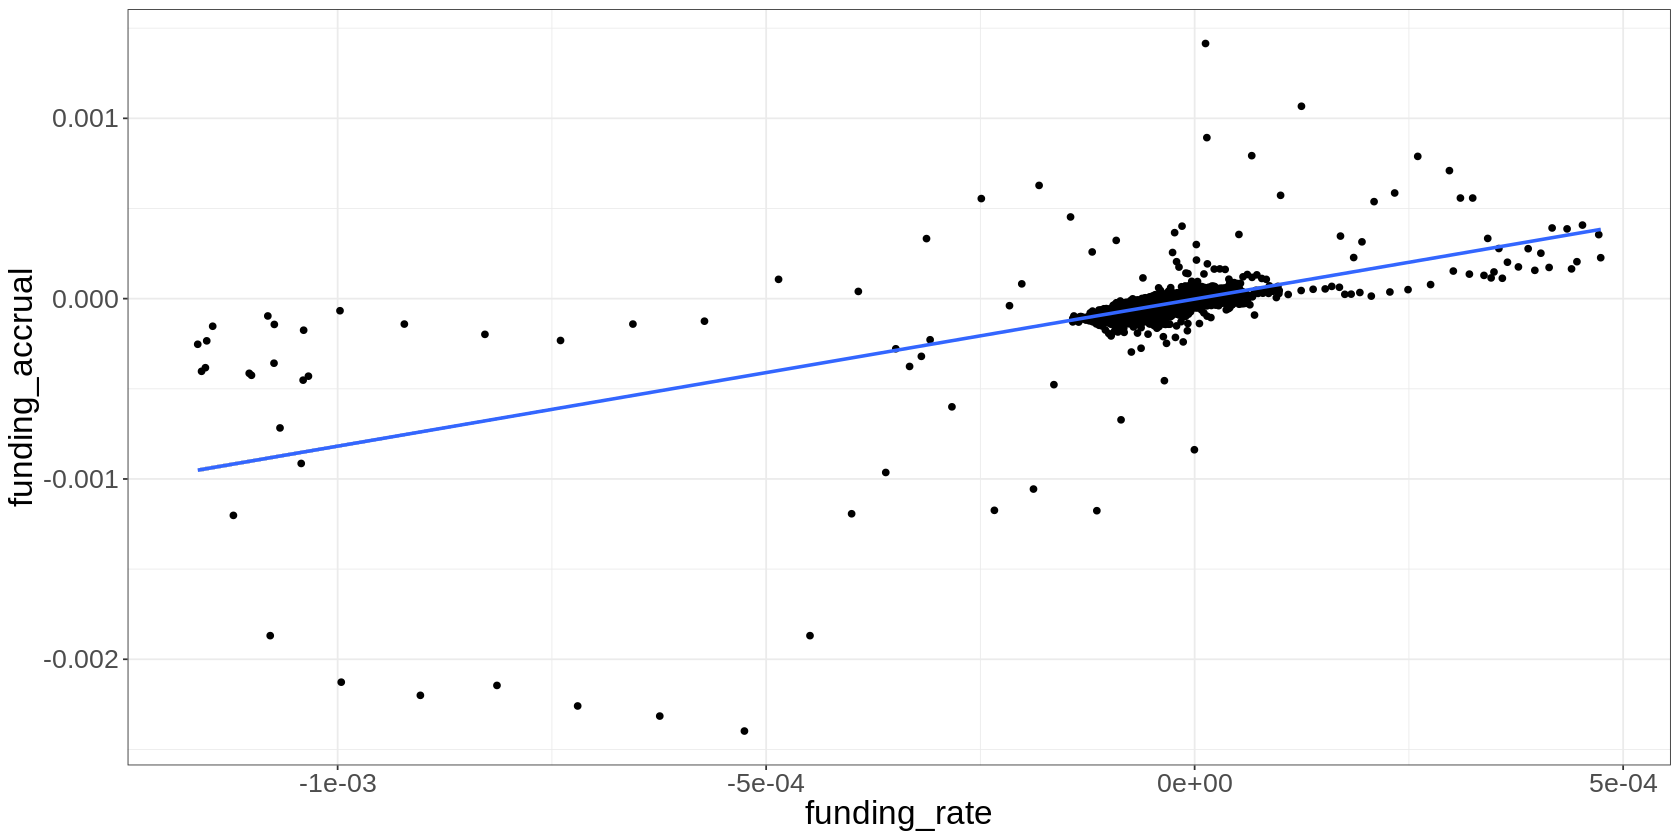

In [8]:
BTC %>%
  ggplot(aes(x=funding_rate, y=funding_accrual)) + 
  geom_point() +
  geom_smooth(method='lm')

Funding seems sticky. If it's paying you to be short now, it's likely to carry on - and vice versa.

# Does funding rate predict price moves?

`geom_smooth()` using formula = 'y ~ x'


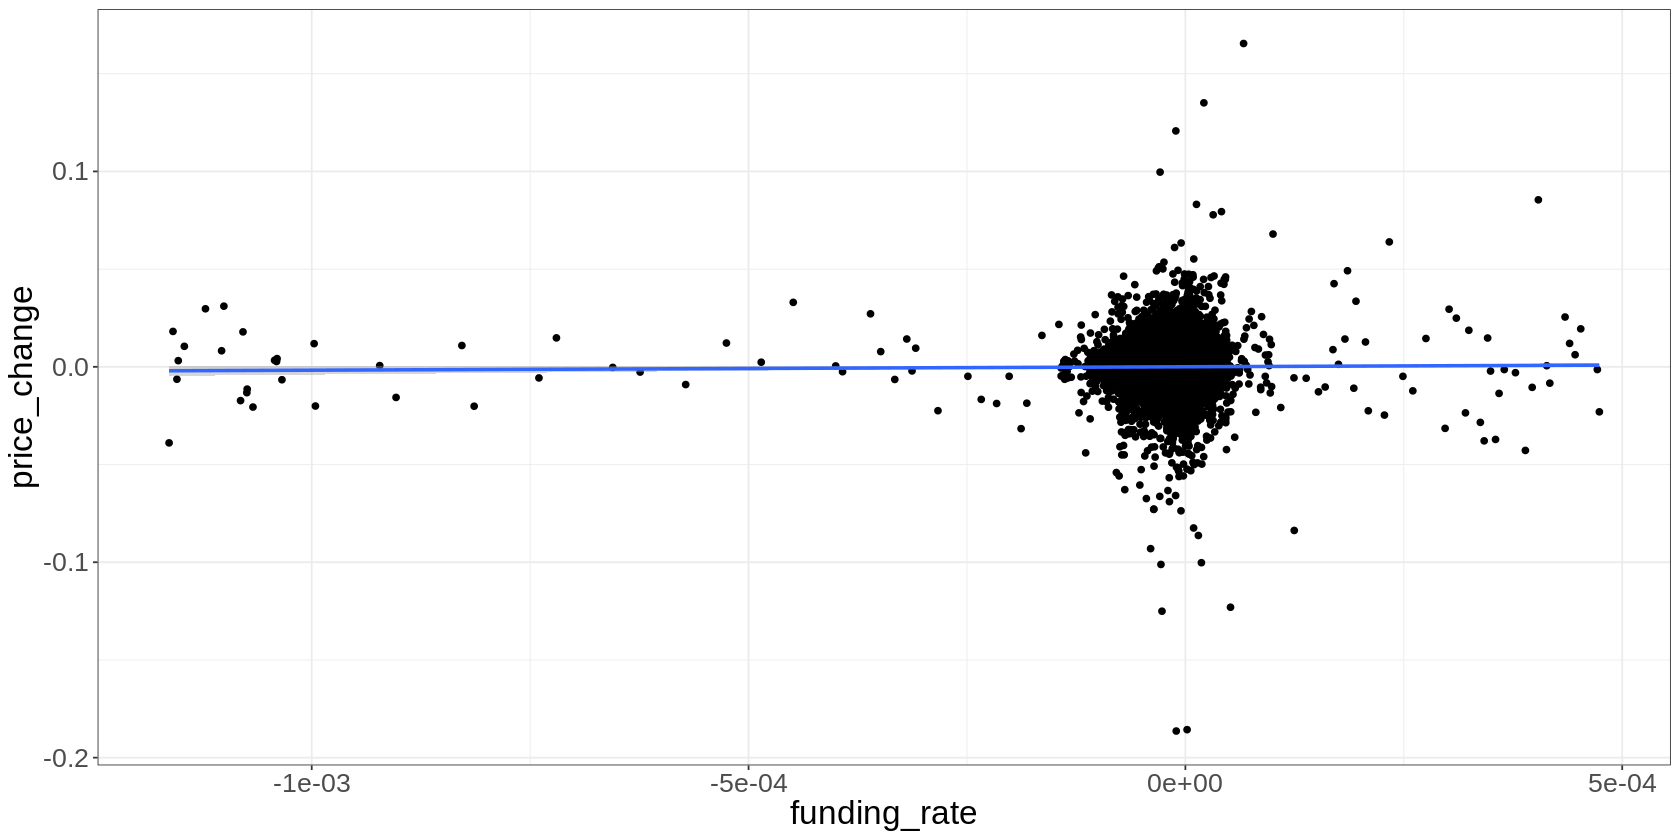

In [9]:
BTC %>%
  ggplot(aes(x=funding_rate, y=price_change)) + 
  geom_point() +
  geom_smooth(method='lm')

Let's look at total returns by funding rate.

`geom_smooth()` using formula = 'y ~ x'


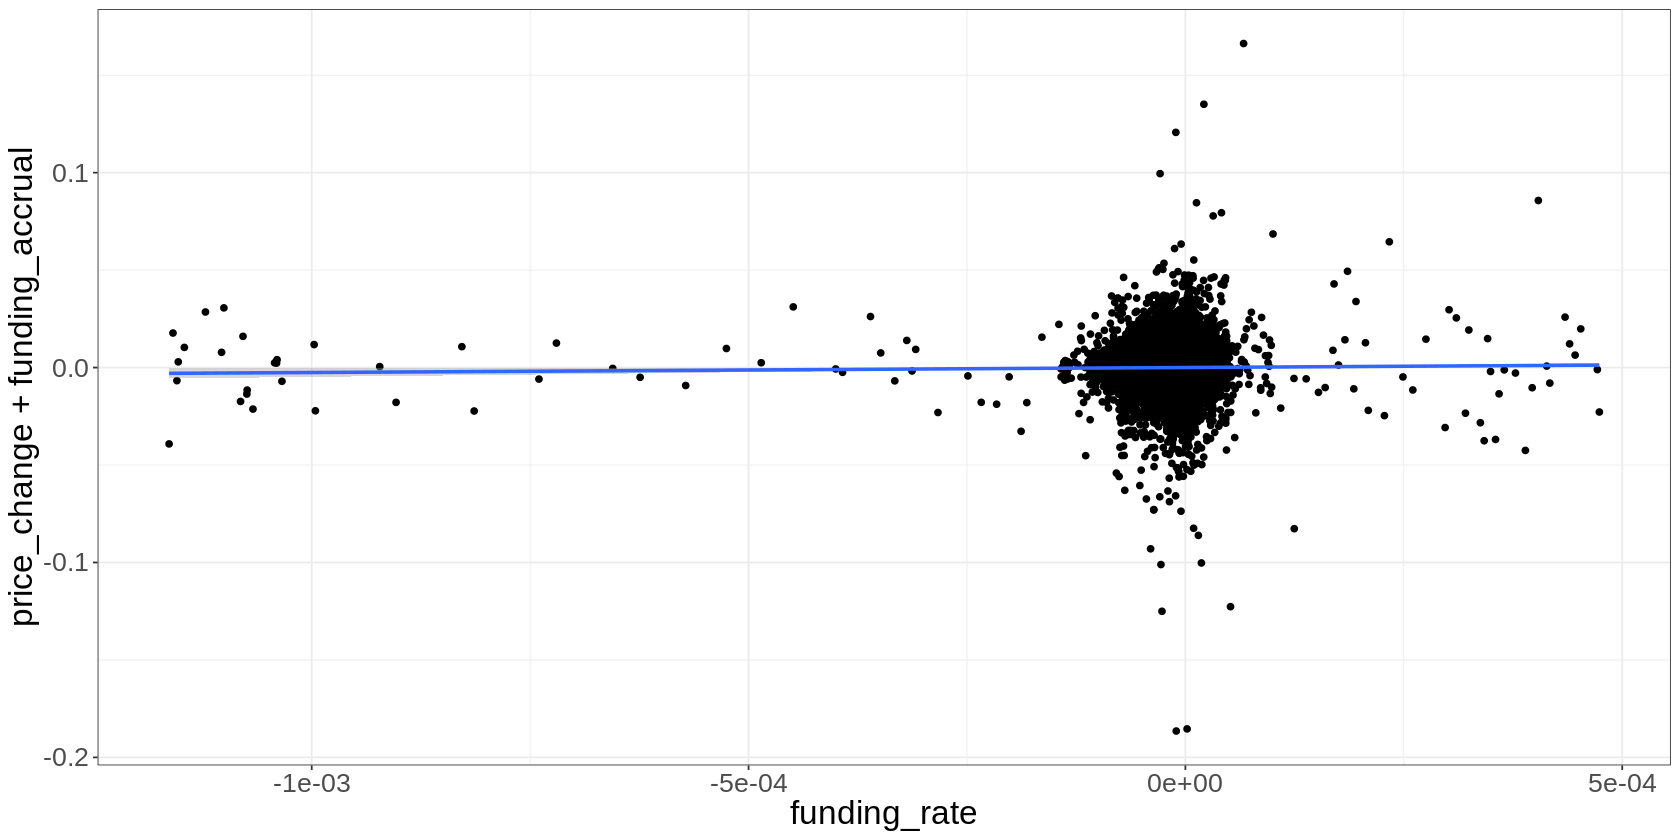

In [10]:
BTC %>%
  ggplot(aes(x=funding_rate, y=price_change + funding_accrual)) + 
  geom_point() +
  geom_smooth(method='lm')

The effect tends to be dominated by volatility of the asset.

But that doesn't deter us - we have tools like diversfication that may help significantly here.